In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib
import pycountry
from shapely.geometry import multipolygon

In [3]:
# Použití vestavěné sady pro informace o každé zemi
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [4]:
# Pomocí knihovny pycountry převede trojmístné kódy zemí na dvoumístné
def make_alpha2(row):
    try:
        alpha_2 = pycountry.countries.get(alpha_3=row["iso_a3"]).alpha_2
    except AttributeError:  
        alpha_2 = "missing"  # Země, která nebyla nalezena podle trojmístného kódu, bude mít v dvoumístném kódu "missing"
    row["alpha2"] = alpha_2
    return row

# Na všechny řádky tabulky aplikuje funkci make_alpha2
countries = countries.apply(make_alpha2, axis=1)
countries

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,alpha2
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJ
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZ
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",EH
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CA
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",US
...,...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888...",RS
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009...",ME
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",missing
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",TT


In [5]:
# Doplnění chybějících 2místných kódů
# Zobrazení zemí, kde kódy chybí
display(countries[countries["alpha2"] == "missing"])

# Ruční doplnění kódů a zemí
countries_missing = ["Norway", "France", "Somaliland", "Kosovo"]
alpha2_miss = ["NO", "FR", "SO", "XK"]

for country_name, alpha in zip(countries_missing, alpha2_miss):
    countries.loc[countries["name"] == country_name, "alpha2"] = alpha
    
# Zbývá ještě kód Severního Kypru, ten jsem ale nenašel

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,alpha2
21,5320045,Europe,Norway,-99,364700.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...",missing
43,67106161,Europe,France,-99,2699000.0,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",missing
160,265100,Asia,N. Cyprus,-99,3600.0,"POLYGON ((32.73178 35.14003, 32.80247 35.14550...",missing
167,3500000,Africa,Somaliland,-99,12250.0,"POLYGON ((48.94820 11.41062, 48.94820 11.41062...",missing
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",missing


(35.0, 60.0)

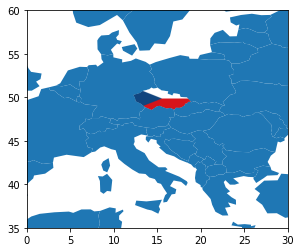

In [6]:
# Vykreslí vlajku Česka - kontrola, že je všechno v pořádku
# Při vlastním spuštění kódu nezapomeňte rozbalit archiv zip v posložce Data
%matplotlib inline

# Načtení souřadnic hranic Česka (slouží k oříznutí obrázku vlajky)
czechia = countries[countries.name == "Czechia"]
czechia_xy = [(x, y) for x, y in czechia.geometry.iloc[0].exterior.coords]

fig, ax = plt.subplots(1, 1)  # Vytvoření prostoru pro graf
img = matplotlib.image.imread("Data/Flags 320px/cz.png")  # Načtení obrázku

countries.plot(ax=ax, zorder=1)


# Vykreslení obrázku na místo České republiky
img_object = ax.imshow(img, 
                       extent=[czechia.bounds.minx.iloc[0], 
                               czechia.bounds.maxx.iloc[0], 
                               czechia.bounds.miny.iloc[0], 
                               czechia.bounds.maxy.iloc[0]],
                      zorder=2)

# Oříznutí obrázku
path = matplotlib.path.Path(czechia_xy)
img_object.set_clip_path(path, transform=ax.transData)


# Nastavení počátečního přiblížení na střední Evropu
ax.set_xlim([0, 30])
ax.set_ylim([35, 60])


In [7]:
# Vytvoření mapy (zobrazuje se v samostatném okně)
%matplotlib auto

# Prostor pro graf a vykreslení spodní vrstvy
fig, ax = plt.subplots(1, 1)
countries.plot(ax=ax, zorder=1)


# Podobný postup jako v předešlé buňce, pouze se provede pro všechny země
for _, row in countries.iterrows():
    if row.alpha2 != "missing":  # Kontrola, že k zemi existuje 2místný kód
        image = matplotlib.image.imread(f"Data/Flags 320px/{row.alpha2}.png")  # Načtení příslušného obrázku
        
        geom_for_image = row.geometry
        

        # U zemí, které obsahují více polygonů, se vybere ten největší
        if type(row.geometry) == multipolygon.MultiPolygon:  
            geom_for_image = max(row.geometry, key=lambda a: a.area)      

            
        # Vykreslení obrázku na místo země
        img_object = ax.imshow(image, 
                           extent=[geom_for_image.bounds[0], 
                                   geom_for_image.bounds[2], 
                                   geom_for_image.bounds[1], 
                                   geom_for_image.bounds[3]],
                          zorder=2)
        
        # Oříznutí obrázku pomocí souřadnic hranic dané země
        country_xy = [(x, y) for x, y in geom_for_image.exterior.coords]
        path = matplotlib.path.Path(country_xy)
        img_object.set_clip_path(path, transform=ax.transData)

# Počáteční přiblížení
ax.set_xlim([-200, 200])
ax.set_ylim([-100, 100])
plt.axis("off")  # Není třeba zobrazovat hodnoty na osách x a y


Using matplotlib backend: Qt5Agg


(-200.0, 200.0, -100.0, 100.0)

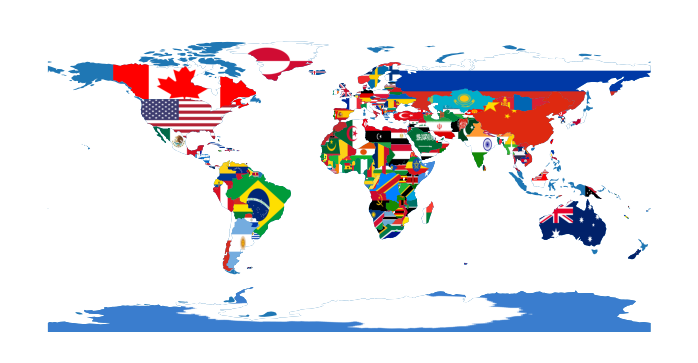

In [8]:
# Zobrazení mapy v buňce

%matplotlib inline
fig